<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/HW002_HINT_Retinopathy_classificationV3_0713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* [kaggle上傳](https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/leaderboard)

In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd #新增

#pytorch
import torch
import torch.nn as nn
from torchsummary import summary # model summary

In [1]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip
!unzip -q retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
From (redirected): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7&confirm=t&uuid=8cf7ea12-75b6-4431-bc2d-d4d630e26802
To: /content/retina-dataset.zip
100% 622M/622M [00:10<00:00, 61.7MB/s]


#### 檢查資料

In [5]:
# Define Parameters
NUM_CLASS = 5
IMG_SIZE = 224
BS = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Data Visualization

In [8]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()
# df.shape #(2197, 2)

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [6]:
#確認資料夾有多少筆照片
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/624fb7317106.png
label: 2


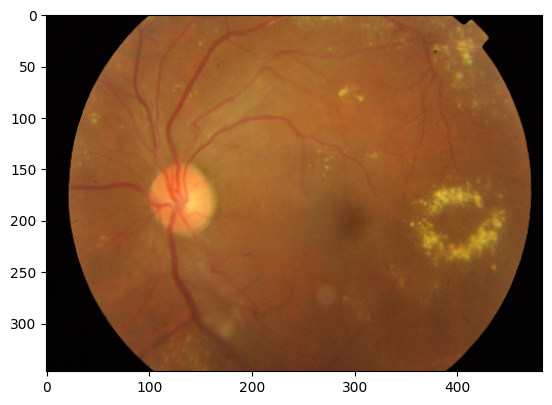

In [21]:
idx = np.random.randint(0, len(df)) #從df中隨機選取一筆資料(取出索引)
row = df.iloc[idx] #透過索引取出那一行的資料
filename = row["id_code"] #取出那一行資料的id_code
path = f"kaggle_retina/train/{filename}.png" #透過檔名尋找照片路徑
img = cv2.imread(path)[:,:,::-1] #mg = cv2.imread(path)[:,:,::-1] img = cv2.imread(path,1)
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [10]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

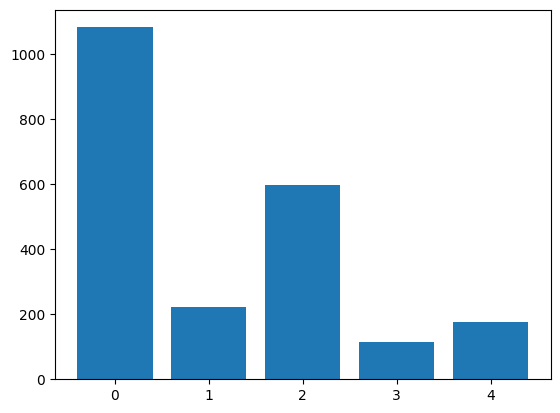

In [11]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Dataset, DataLoader

In [25]:
import imgaug.augmenters as iaa #用於圖像增強
import imgaug as ia

class RetinaDataset(torch.utils.data.Dataset): #處理和增強視網膜圖像數據
    def __init__(self, df, aug, img_size=224):
        self.df = df
        self.transform = iaa.Sequential([  #定義了一系列圖像增強操作，包括水平翻轉、垂直翻轉、旋轉、剪切和縮放
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.Affine(
                rotate=(-45, 45),
                shear=(-16,16),
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
            ),
        ])
        self.aug = aug #一個布爾值，指示是否應用數據增強
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png"
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (self.img_size, self.img_size))
        if self.aug:
            img = self.transform.augment_image(image=img)
        img = img / 255.
        label = row["diagnosis"]

        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [26]:
#分割訓練集和驗證集
df = pd.read_csv("kaggle_retina/train.csv")
train_df, val_df = train_test_split(df,
                                    test_size=0.2, #驗證集將包含總數據的20%，其餘80%用作訓練集
                                    random_state=5566)

In [27]:
#進行數據集增強
train_ds = RetinaDataset(train_df, aug=True, img_size=IMG_SIZE)
val_ds = RetinaDataset(val_df, aug=False, img_size=IMG_SIZE)

377 tensor(2)


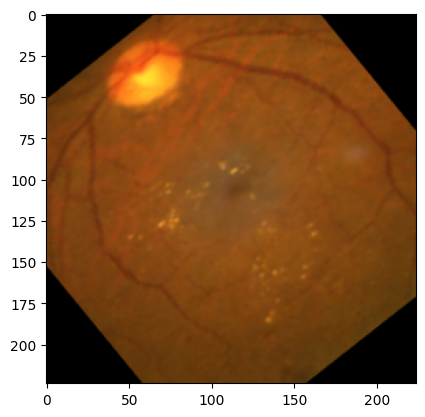

In [28]:
#檢視增強數據
idx = np.random.randint(0, len(train_ds))
img, label = train_ds[idx]
print(idx, label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [29]:
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

#### [TODO] Model

In [51]:
class ConvBN(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, kernel_size=3, padding='same')
        self.bn = nn.BatchNorm2d(num_features=cout)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.act(x)

class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBN(3, 16),
            ConvBN(16, 16),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(16, 32),
            ConvBN(32, 32),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(32, 64),
            ConvBN(64, 64),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten() # 50716/64=784 784開根號=28
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*28*28, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASS),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [52]:
# Build a model and move to GPU device
model = CNN(kernel_size=7).to(device)

In [53]:
print(model)

CNN(
  (encoder): Sequential(
    (0): ConvBN(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBN(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBN(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (4): ConvBN(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, s

In [54]:
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            ConvBN-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           2,320
       BatchNorm2d-6         [-1, 16, 224, 224]              32
              ReLU-7         [-1, 16, 224, 224]               0
            ConvBN-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           ConvBN-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

#### Training

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [56]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [57]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 4.3894, train_acc: 0.442     val_loss: 1.3003, val_acc: 0.523 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.1888, train_acc: 0.550     val_loss: 1.1011, val_acc: 0.609 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.1229, train_acc: 0.586     val_loss: 0.9903, val_acc: 0.645 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.0791, train_acc: 0.614     val_loss: 0.9096, val_acc: 0.673 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.0511, train_acc: 0.627     val_loss: 0.8506, val_acc: 0.686 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 1.0229, train_acc: 0.634     val_loss: 0.9291, val_acc: 0.657 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.9716, train_acc: 0.645     val_loss: 1.0199, val_acc: 0.650 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.9844, train_acc: 0.655     val_loss: 0.9246, val_acc: 0.677 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.9869, train_acc: 0.653     val_loss: 0.9372, val_acc: 0.657 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.9281, train_acc: 0.674     val_loss: 0.8036, val_acc: 0.705 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.8864, train_acc: 0.677     val_loss: 0.8421, val_acc: 0.702 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.9275, train_acc: 0.679     val_loss: 0.8368, val_acc: 0.700 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.8992, train_acc: 0.681     val_loss: 0.7947, val_acc: 0.714 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.8919, train_acc: 0.685     val_loss: 0.8285, val_acc: 0.709 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.8786, train_acc: 0.696     val_loss: 0.8302, val_acc: 0.714 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.8707, train_acc: 0.686     val_loss: 0.8190, val_acc: 0.723 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.8944, train_acc: 0.678     val_loss: 0.8040, val_acc: 0.720 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.8570, train_acc: 0.696     val_loss: 0.8380, val_acc: 0.693 
Earlystop!


#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [58]:
model.load_state_dict(torch.load('best.pth'))
_ = model.eval().to(device)

In [59]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_size=224):
        self.df = df
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, IMG_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [60]:
# Inference
y_pred = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

In [61]:
df['diagnosis'] = y_pred
df.to_csv('submission.csv', index=None)

### 爆錯原因解釋
* 爆錯內容: 顯示ma1and ma2 shape cannot be multipiled(2x100352 and 131072x3)

In [37]:
import torch

In [39]:
input=torch.randn(2,1000)
input.shape

torch.Size([2, 1000])

In [40]:
layer=nn.Linear(1300,3)

In [44]:
output=layer(input)

RuntimeError: ignored

In [46]:
layer1=nn.Linear(1000,3)

In [47]:
output=layer1(input)

In [49]:
output.shape

torch.Size([2, 3])

In [50]:
output

tensor([[-0.3742, -0.7782, -0.1785],
        [-0.3626,  0.2618, -0.2219]], grad_fn=<AddmmBackward0>)